In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"  # specify which GPU(s) to be used>
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
import sys
import math
import time
import random
import typing
import imageio
import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import metrics
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from einops.layers.torch import Rearrange
from sklearn.model_selection import train_test_split

import torch as T
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.adam import Adam
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import datasets, models, transforms
from torchvision.models.resnet import resnet50
from kornia.utils.one_hot import one_hot
from sklearn.model_selection import StratifiedKFold

## Load PTH
We previolusly obtained each PTH(weights) from a training process. Now it is neccesary to adquire the embeddings

In [4]:
root = os.getcwd()

In [5]:
weight_paths = "results/Journal_SPIE_1S_2H_binary_kfold"
fold_weight_path = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold")
fold_weight_path_0 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_0.pth")
fold_weight_path_1 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_1.pth")
fold_weight_path_2 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_2.pth")
fold_weight_path_3 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_3.pth")
fold_weight_path_4 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_4.pth")
fold_weight_path_5 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_5.pth")
fold_weight_path_6 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_6.pth")
fold_weight_path_7 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_7.pth")
fold_weight_path_8 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_8.pth")
fold_weight_path_9 = os.path.join(root, weight_paths, "Journal_SPIE_1S_2H_binary_kfold_fold_9.pth")
print("Folder of PTH model: ", fold_weight_path_0)
print("Folder of PTH model: ", fold_weight_path)

Folder of PTH model:  /home/arumota/results/Journal_SPIE_1S_2H_binary_kfold/Journal_SPIE_1S_2H_binary_kfold_fold_0.pth
Folder of PTH model:  /home/arumota/results/Journal_SPIE_1S_2H_binary_kfold/Journal_SPIE_1S_2H_binary_kfold_fold


## Loading each model 
But, if we want to load the PTH, we need to do certain steps, such as declare each model


In [6]:
def conv3x3_3d(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv3d(in_planes, out_planes, kernel_size=(3, 3, 3), stride=stride, padding=1, bias=False)

class Basic3dBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Basic3dBlock, self).__init__()
        self.conv1 = conv3x3_3d(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3_3d(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        out += identity
        out = self.relu(out)

        return out

In [7]:
class BasicConv3dRBF(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv3dRBF, self).__init__()
        self.conv = nn.Conv3d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm3d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x

In [8]:
class RBF_modified(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(RBF_modified, self).__init__()
        self.relu = nn.ReLU(True)
        self.branch0 = nn.Sequential(
            BasicConv3dRBF(in_channel, out_channel, (1, 1, 1)),
        )
        self.branch1 = nn.Sequential(
            BasicConv3dRBF(in_channel, out_channel, (1, 1, 1)),
            BasicConv3dRBF(out_channel, out_channel, kernel_size=(1, 3, 1), padding=(0, 1, 0)),
            BasicConv3dRBF(out_channel, out_channel, kernel_size=(3, 1, 1), padding=(1, 0, 0)),
            BasicConv3dRBF(out_channel, out_channel, (3, 3, 3), padding=3, dilation=3)
        )
        self.branch2 = nn.Sequential(
            BasicConv3dRBF(in_channel, out_channel, (1, 1, 1)),
            BasicConv3dRBF(out_channel, out_channel, kernel_size=(1, 5, 1), padding=(0, 2, 0)),
            BasicConv3dRBF(out_channel, out_channel, kernel_size=(5, 1, 1), padding=(2, 0, 0)),
            BasicConv3dRBF(out_channel, out_channel, (3, 3, 3), padding=5, dilation=5)
        )
        self.branch3 = nn.Sequential(
            BasicConv3dRBF(in_channel, out_channel, (1, 1, 1)),
            BasicConv3dRBF(out_channel, out_channel, kernel_size=(1, 7, 1), padding=(0, 3, 0)),
            BasicConv3dRBF(out_channel, out_channel, kernel_size=(7, 1, 1), padding=(3, 0, 0)),
            BasicConv3dRBF(out_channel, out_channel, (3, 3, 3), padding=7, dilation=7)
        )
        self.conv_cat = BasicConv3dRBF(4*out_channel, out_channel, (3, 3, 3), padding=1)
        self.conv_res = BasicConv3dRBF(in_channel, out_channel, (1, 1, 1))

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = self.conv_cat(T.cat((x0, x1, x2, x3), 1))

        x = self.relu(x_cat + self.conv_res(x))
        
        return x

In [9]:
class RFBMultiHeadAttn_V2(nn.Module):
    def __init__(self, in_dim, filters_head, num_multiheads):
        super(RFBMultiHeadAttn_V2, self).__init__()  
        """
            Multi-head attention
            in_dim = entry dimmension
            filters_head = filters by head
            We plan to make as much attentions as possible, in order to provide a reliable
            classification. Thus, creating different types of projections called k, q and v.
        """    
        self.in_dim = in_dim
        self.filters_head = filters_head
        self.num_multiheads = num_multiheads
        self.inner_filters = filters_head * num_multiheads

        #Queries of each attention made
        self.qkv_rfb = RBF_modified(in_dim, self.inner_filters * 3)

        self.rearrange_for_matmul = Rearrange(
            #"b c (d nh) h w  -> b c nh d h w", nh=num_multiheads
            "b (nh c) d h w  -> b nh c d h w", nh=num_multiheads
        )
        self.rearrange_back = Rearrange("b nh c d h w -> b (c nh) d h w")
        self.rearrange_for = Rearrange("nh b c d h w -> b (c nh) d h w")
        self.gamma_one = nn.Parameter(T.zeros(1))
        self.gamma_two = nn.Parameter(T.zeros(1))
        self.gamma_thr = nn.Parameter(T.zeros(1))
        self.gamma_fou = nn.Parameter(T.zeros(1))
        self.gamma_fiv = nn.Parameter(T.zeros(1))
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X D X W X H)
            returns :
                out : self attention value + input feature + num of heads
                attention: B X C X D X N (N is Width*Height)
        """
        
        #It is important to obtain a size of the input
        m_batchsize, C, dim, width, height = x.size()
#         print("x:        ", x.shape)
        #Now, we're gonna obtain an attention for each one 
#         print(self.qkv_rfb(x).shape)
        proj_qkv = self.qkv_rfb(x).view(m_batchsize, -1, dim, width, height)
#         print("proj_qkv: ", proj_qkv.shape)
        proj_qkv_rearranged = self.rearrange_for_matmul(proj_qkv)
#         print("rearanfed:", proj_qkv_rearranged.shape)
        q, k, v = proj_qkv_rearranged.chunk(chunks=3, dim=2)
#         print(q.shape, k.shape, v.shape)

        sim = (k @ q.permute(0, 1, 2, 3, 5, 4))
        att_map = self.softmax(sim)  # BX (N) X (N)
        proj_v = att_map @ v
#         print("proj_v:   ", proj_v.shape)
        out_att = self.rearrange_back(proj_v)
#         print("out_att:  ", out_att.shape)
        out_heads = out_att.chunk(chunks=self.num_multiheads, dim=1)
#         print("out_heads:", out_heads[0].shape, out_heads[1].shape, out_heads[2].shape)
        out_gamma = T.cat([self.gamma_one,self.gamma_two,self.gamma_thr,self.gamma_fou,self.gamma_fiv])
        result = T.stack([(out_gamma[index] * heads + x) for index, heads in enumerate(out_heads)])
#         print("result;   ", result.shape)
        return self.rearrange_for(result)

In [10]:
#If you want to print inside the sequential module
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.size())
        return x

In [11]:
class RFBMultiHAttnNetwork_V3(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads = 3
        self.RFBMHA_V3 = nn.Sequential(
            Basic3dBlock(1, 32),
            RFBMultiHeadAttn_V2(32, 32, self.heads),
            nn.BatchNorm3d(32*self.heads),
            nn.Dropout(0.1),
#             Basic3dBlock(32*self.heads, 32*self.heads),      
#             RFBMultiHeadAttn_V2(32*self.heads, 32*self.heads, self.heads),
#             nn.BatchNorm3d(32*self.heads*self.heads),
#             nn.Dropout(0.1),
            nn.AdaptiveAvgPool3d((1,1,1)),
            #PrintLayer()
        )
        self.fc1 = nn.Linear(32*self.heads, 1)


    def forward(self, x):
        x = self.RFBMHA_V3(x)
        x = x.view(-1, x.size()[1])
        x = self.fc1(x)
        x = T.sigmoid(x)
        return x 

## Preprocessing the data 
But, if we want to load the PTH, we need to do certain steps, such as load the data


In [12]:
LIDC_path = "/data/Datasets/Pulmonary_nodules/LIDC_IDRI/LIDC-IDRI_images_npy_3d_HU"
#LIDC_path = "/home/Data/Datasets/Pulmonary_nodules/LIDC_IDRI/LIDC-IDRI_images_npy_3d_HU"
print(len(os.listdir(LIDC_path)))
min_val = 90000
max_val = 0
for i, value in enumerate(os.listdir(LIDC_path)):
    if (value == "meta_created_info_3d.csv"): continue;
    elif(value == "meta_created_info_3d_4R.csv"): continue;
    elif(value == "meta_created_info_3d_3R.csv"): continue;
    elif(value == "meta_created_info_3d_4R_binary.csv"): continue;
    elif(value == "meta_created_info_3d_3R_binary.csv"): continue;
    elif(value == "meta_created_info_3d_1stRAD.csv"): continue;
    elif(value == "meta_created_info_3d_2ndRAD.csv"): continue;
    elif(value == "meta_created_info_3d_3rdRAD.csv"): continue;
    elif(value == "meta_created_info_3d_4thRAD.csv"): continue;        
    elif(value == "meta_created_info_3d_1stRAD_all.csv"): continue;        
    elif(value == "meta_created_info_3d_2ndRAD_all.csv"): continue;        
    elif(value == "meta_created_info_3d_3rdRAD_all.csv"): continue;        
    elif(value == "meta_created_info_3d_4thRAD_all.csv"): continue;        
    elif(value == "meta_created_info_3d_1stRAD_diameter.csv"): continue;        
    elif(value == "meta_created_info_3d_2ndRAD_diameter.csv"): continue;        
    elif(value == "meta_created_info_3d_3rdRAD_diameter.csv"): continue;        
    elif(value == "meta_created_info_3d_4thRAD_diameter.csv"): continue;
    else:
        patient_folder = os.path.join(LIDC_path,value)
        length_folder  = len(os.listdir(patient_folder)) 
        if (length_folder > max_val): max_val = length_folder
        if (length_folder < min_val): min_val = length_folder
        #if (length_folder == 1): print(value)
print("Max value", max_val)
print("Min value", min_val)

2642
Max value 57
Min value 1


In [13]:
df_3R = pd.read_csv(os.path.join(LIDC_path, "meta_created_info_3d_3R.csv")) 
df_4R = pd.read_csv(os.path.join(LIDC_path, "meta_created_info_3d_4R.csv")) 
df = pd.concat([df_4R, df_3R])
# df_benign = df_all[df_all['malignancy']<3]
# df_malign = df_all[df_all['malignancy']>3]
# df = pd.concat([df_benign, df_malign])
df

,patient_id,nodule_no,folder,malignancy,is_cancer,calcification,lobulation,texture,spiculation,subtlety,margin,intercept,slope
0,1,0,LICD-0001_NI000,5,True,6,3,5,5,5,4,-1024.0,1.0
1,3,1,LICD-0003_NI001,5,True,6,2,4,3,5,3,-1024.0,1.0
2,3,2,LICD-0003_NI002,4,True,6,2,5,2,4,4,-1024.0,1.0
3,3,3,LICD-0003_NI003,4,True,6,1,5,1,4,5,-1024.0,1.0
4,4,0,LICD-0004_NI000,1,False,3,1,5,1,3,5,-1024.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,390,7,LICD-0390_NI007,1,False,3,1,5,1,3,5,-1024.0,1.0
30,394,1,LICD-0394_NI001,3,Ambiguous,6,2,5,1,4,4,-1024.0,1.0
31,399,0,LICD-0399_NI000,2,False,6,2,5,1,4,5,-1024.0,1.0
32,402,4,LICD-0402_NI004,3,Ambiguous,6,1,1,1,2,2,-1024.0,1.0


In [14]:
df.groupby('malignancy').count()['patient_id']

malignancy
1    121
2     53
3    388
4    203
5    156
Name: patient_id, dtype: int64

In [15]:
def hu_normalize(im, slope, intercept):
    """normalize the image to Houndsfield Unit
    """
    im = im * slope + intercept
    im[im > 400] = 400
    im[im < -1000] = -1000

    im = (255 - 0)/(400 - (-1000)) * (im - 400) + 255

    return im.astype(np.uint8)

In [16]:
#Please have a try with this manner
data_transforms = transforms.Compose([
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])

#datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])

class Augmenter:
    def __init__(self, hflip=True, rotate=True, blurring=False):
        self.hflip = hflip
        self.rotate = rotate
        self.blurring = blurring

    def augment(self, x):
        im = Image.fromarray(x)
        yield im
        if self.hflip:
            yield im.transpose(Image.FLIP_LEFT_RIGHT)
        if self.rotate:
            yield im.transpose(Image.ROTATE_90)
            yield im.transpose(Image.ROTATE_180)
            yield im.transpose(Image.ROTATE_270)
        if self.blurring:
            yield im.filter(ImageFilter.GaussianBlur(1))

In [17]:
nodule_size = 16
X_train, X_test, y_train, y_test = train_test_split(df["folder"], df["malignancy"], test_size=0.20, random_state=100)
print(len(y_test), len(y_train))
num_data = len(X_train)
img_size = 32

x = T.zeros((num_data, 1, 5, img_size, img_size))
y = T.zeros((num_data, 1))


for c, row in enumerate(X_train):
    patient_folder  = os.path.join(LIDC_path,row)
    length_folder   = len(os.listdir(patient_folder)) 
    image_folder    = sorted(os.listdir(patient_folder))
    middle_value    = len(image_folder)//2
    
    if (length_folder == 1): 
        tensor_image_3d = [image_folder, image_folder, image_folder, image_folder, image_folder]
    elif (length_folder == 2): 
        tensor_image_3d = [image_folder[0], image_folder[0], image_folder[1], image_folder[1], image_folder[1]]
    elif (length_folder == 3): 
        tensor_image_3d = [image_folder[0], image_folder[0], image_folder[1], image_folder[2], image_folder[2]]
    elif (length_folder == 4): 
        tensor_image_3d = [image_folder[0], image_folder[1], image_folder[2], image_folder[3], image_folder[3]]
    elif (length_folder >= 5): 
        tensor_image_3d = [image_folder[middle_value-2], image_folder[middle_value-1], image_folder[middle_value], 
                           image_folder[middle_value+1], image_folder[middle_value+2]]
    patient = df[df['folder'] == row]
    
    for i, value in enumerate(tensor_image_3d):
        
        im = np.load(os.path.join(root, patient_folder, value))
        im = im - np.min(im)
        im = ((im/np.max(im))*255).astype(np.uint8)
        width, height = im.shape; width = width//2; height = height//2
        if((im.shape[0] < 32) or (im.shape[1] < 32)): im = cv.resize(im, (32, 32))
        elif((im.shape[0] < width+nodule_size) or (im.shape[1] < width+nodule_size)): im = cv.resize(im, (32, 32))
        else: im = im[width-nodule_size:width+nodule_size, width-nodule_size:width+nodule_size]
        
        x[c, 0, i, :, :] = T.from_numpy(np.array(im).astype(np.float32))
        if(int(patient.malignancy) == 1): y[c, 0:] = int(0)
        if(int(patient.malignancy) == 2): y[c, 0:] = int(1)
        if(int(patient.malignancy) == 4): y[c, 0:] = int(1)
        if(int(patient.malignancy) == 5): y[c, 0:] = int(1)

print("x: ",x.shape)
print("y: ",y.shape)

185 736
x:  torch.Size([736, 1, 5, 32, 32])
y:  torch.Size([736, 1])


torch.Size([1, 5, 32, 32])


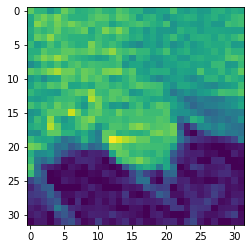

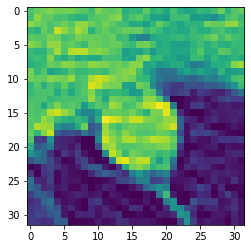

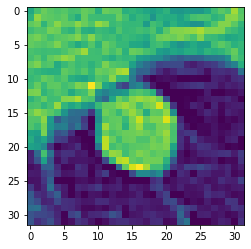

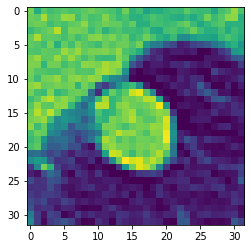

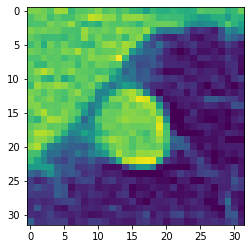

torch.Size([1, 5, 32, 32])


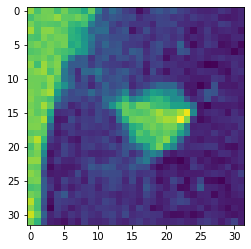

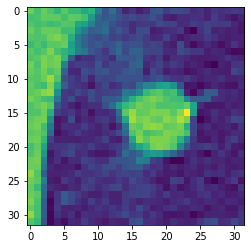

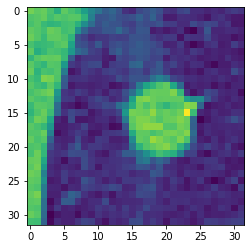

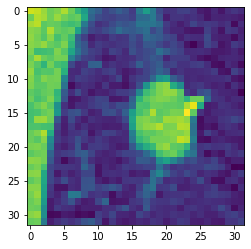

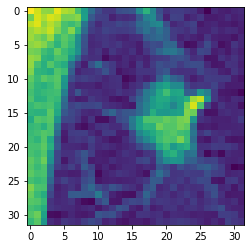

torch.Size([1, 5, 32, 32])


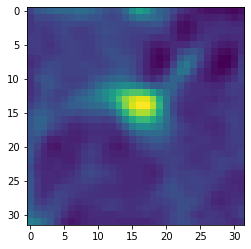

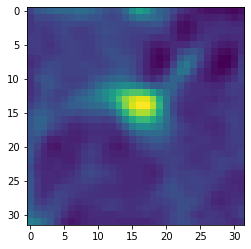

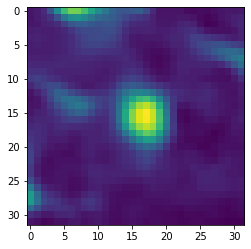

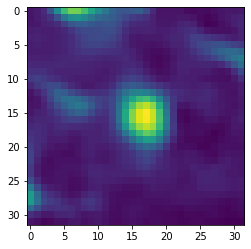

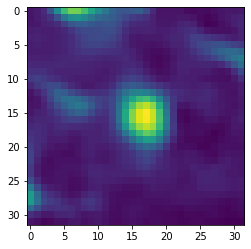

torch.Size([1, 5, 32, 32])


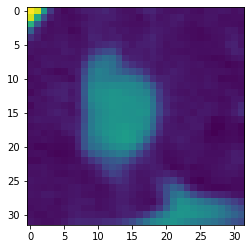

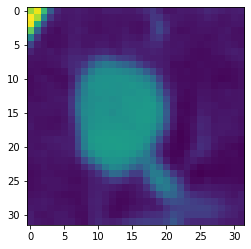

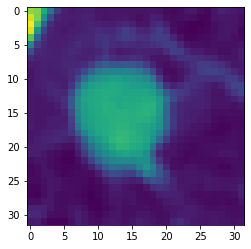

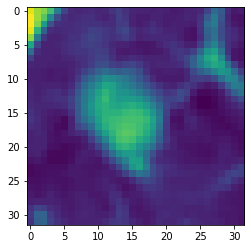

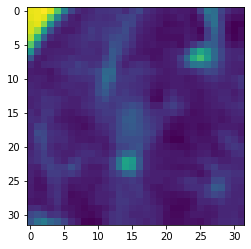

torch.Size([1, 5, 32, 32])


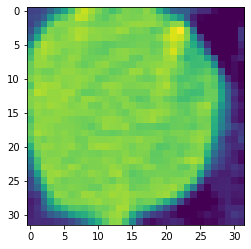

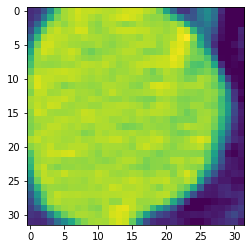

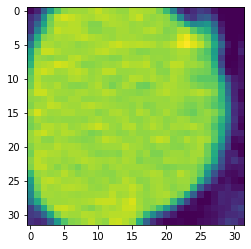

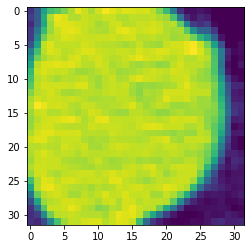

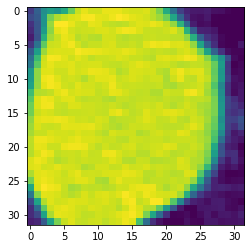

torch.Size([1, 5, 32, 32])


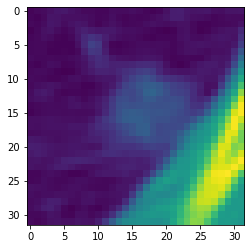

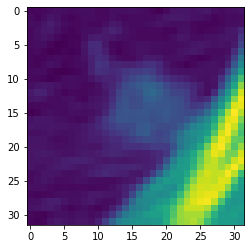

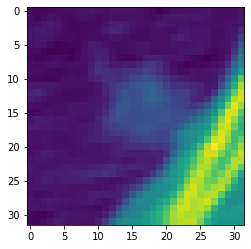

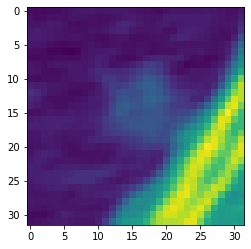

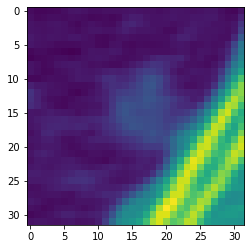

torch.Size([1, 5, 32, 32])


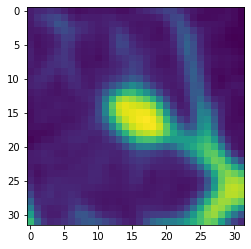

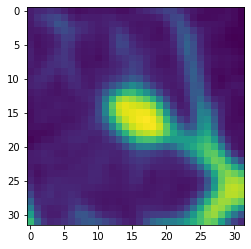

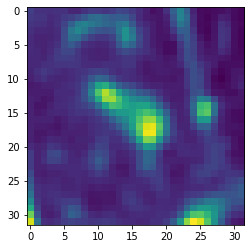

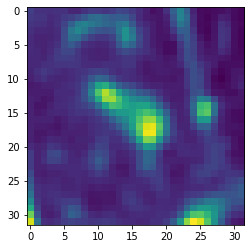

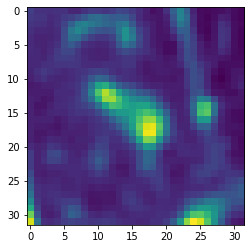

torch.Size([1, 5, 32, 32])


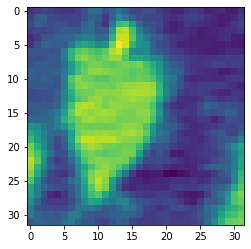

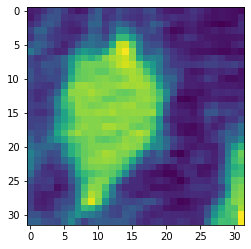

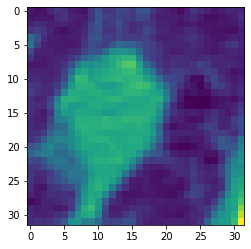

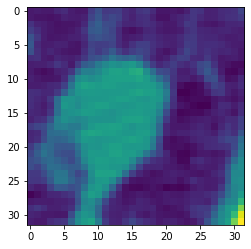

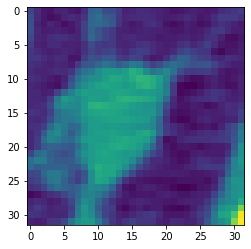

torch.Size([1, 5, 32, 32])


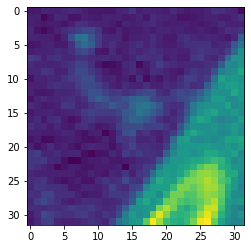

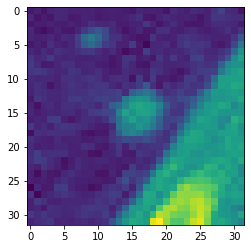

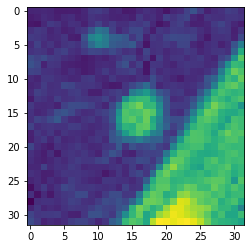

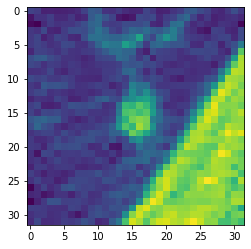

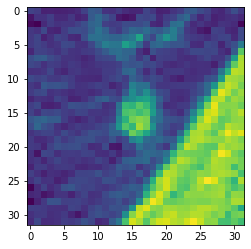

torch.Size([1, 5, 32, 32])


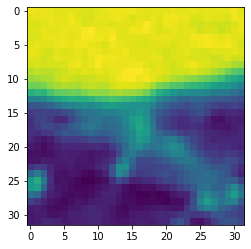

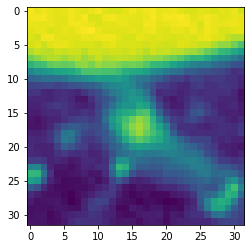

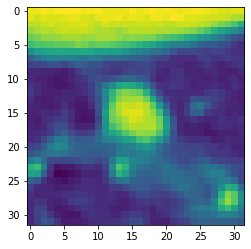

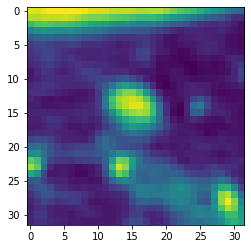

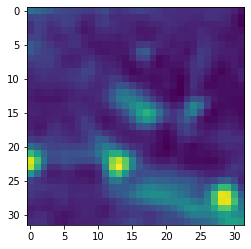

torch.Size([1, 5, 32, 32])


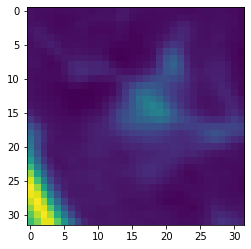

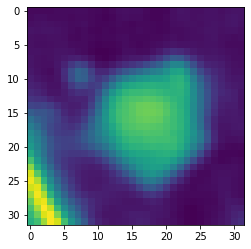

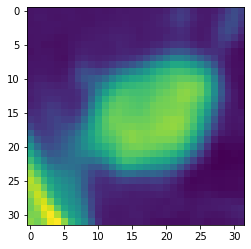

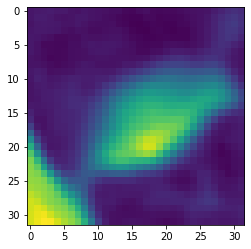

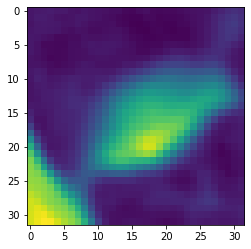

torch.Size([1, 5, 32, 32])


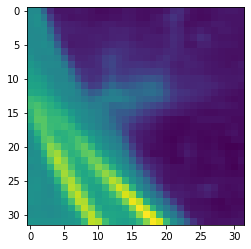

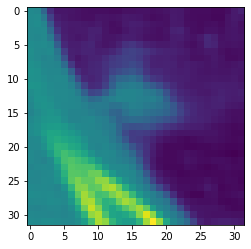

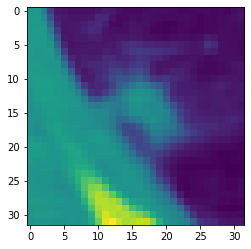

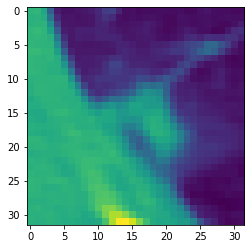

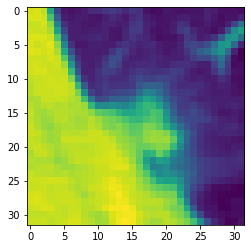

torch.Size([1, 5, 32, 32])


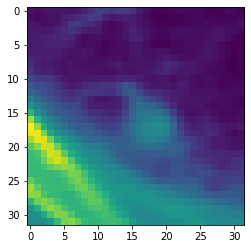

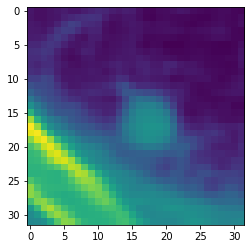

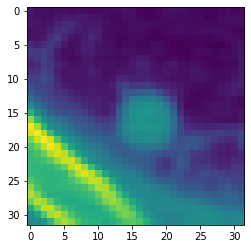

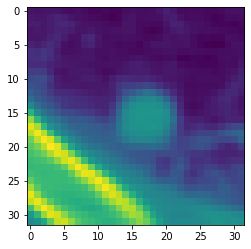

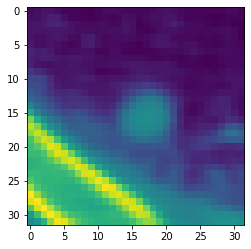

torch.Size([1, 5, 32, 32])


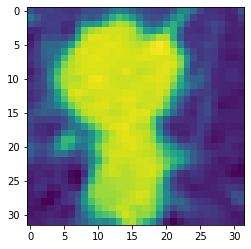

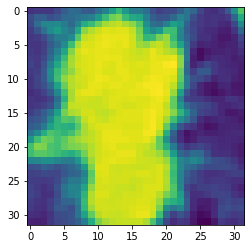

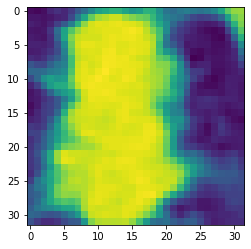

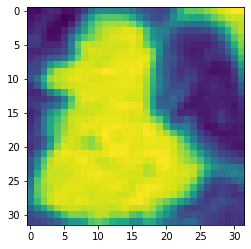

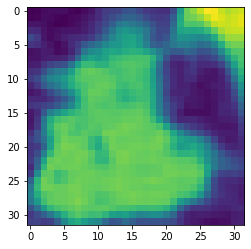

torch.Size([1, 5, 32, 32])


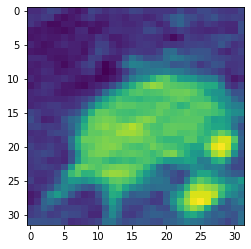

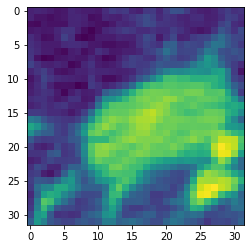

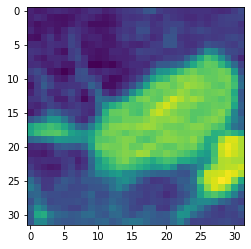

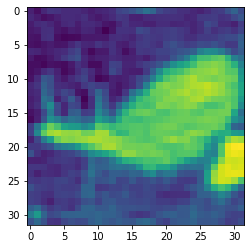

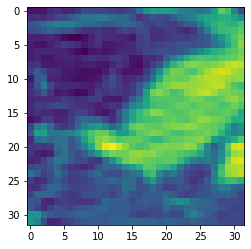

torch.Size([1, 5, 32, 32])


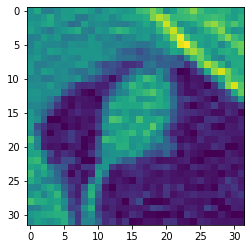

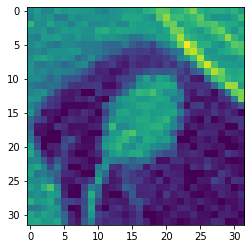

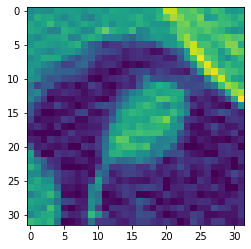

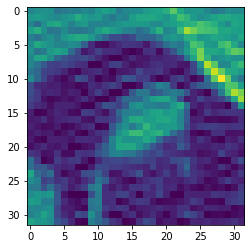

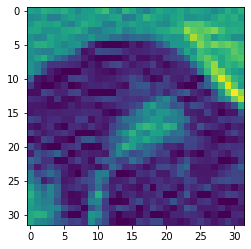

torch.Size([1, 5, 32, 32])


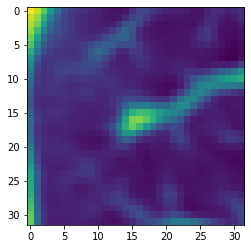

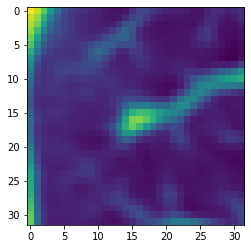

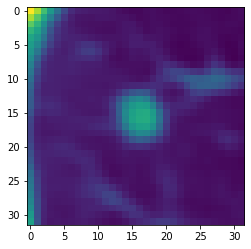

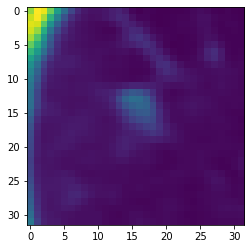

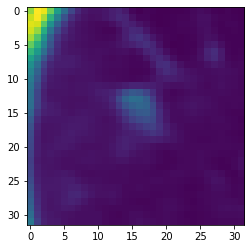

torch.Size([1, 5, 32, 32])


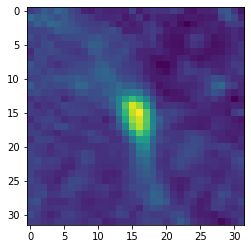

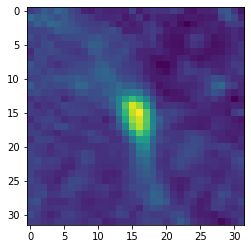

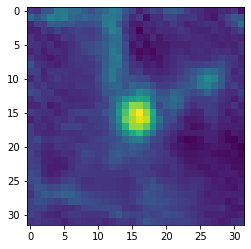

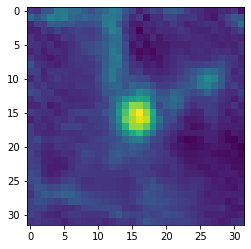

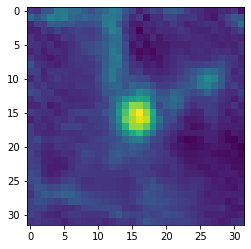

torch.Size([1, 5, 32, 32])


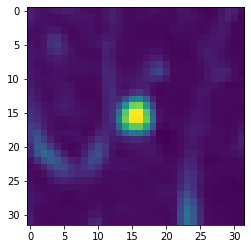

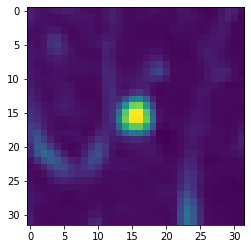

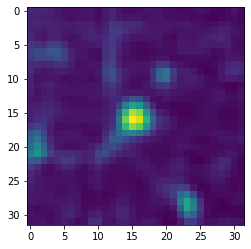

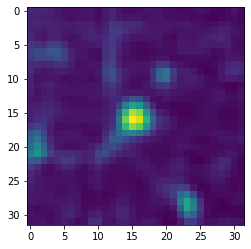

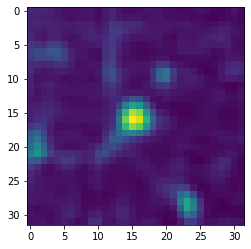

torch.Size([1, 5, 32, 32])


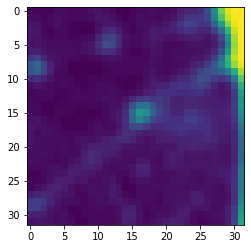

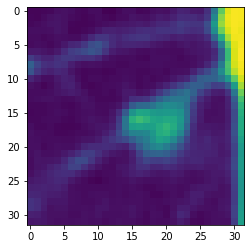

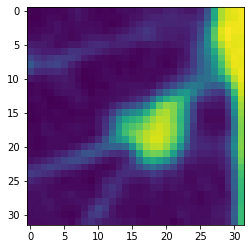

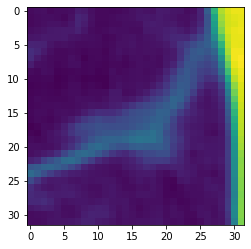

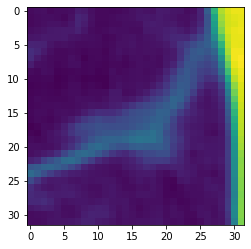

torch.Size([1, 5, 32, 32])


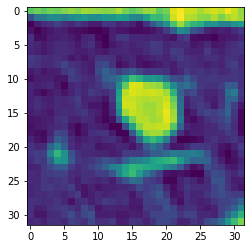

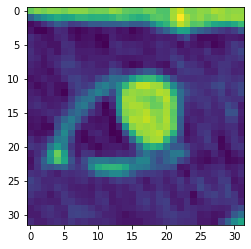

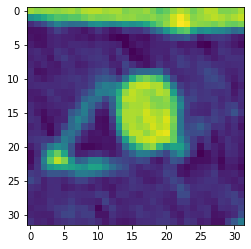

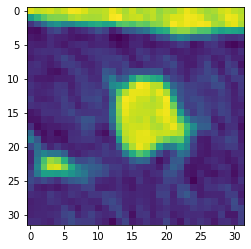

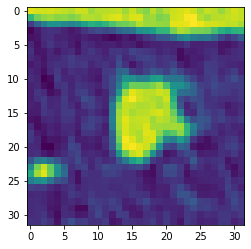

torch.Size([1, 5, 32, 32])


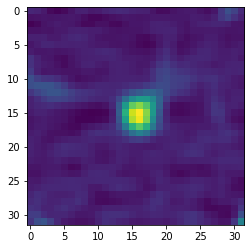

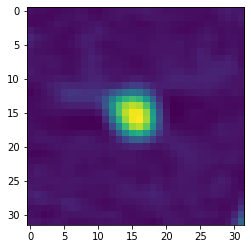

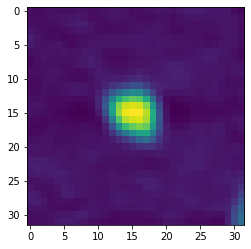

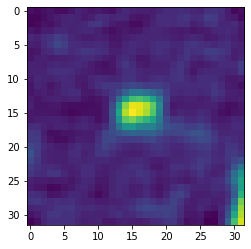

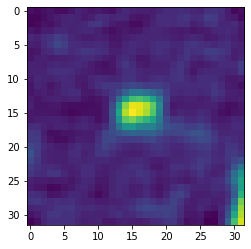

torch.Size([1, 5, 32, 32])


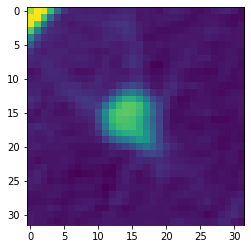

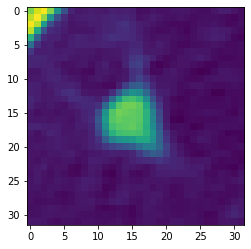

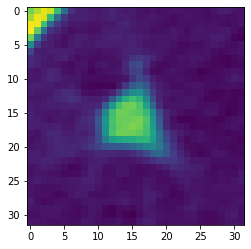

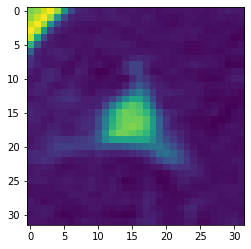

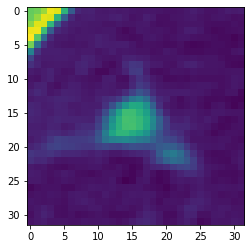

torch.Size([1, 5, 32, 32])


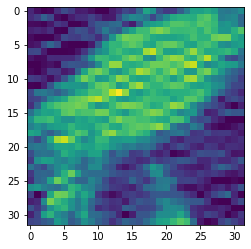

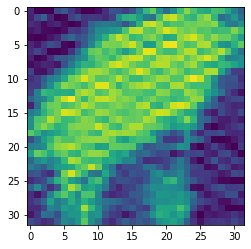

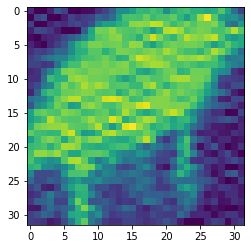

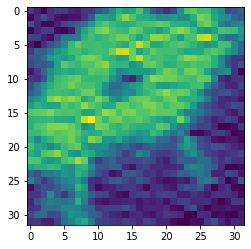

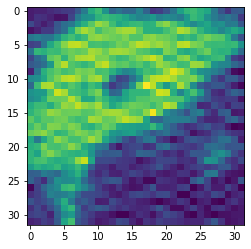

torch.Size([1, 5, 32, 32])


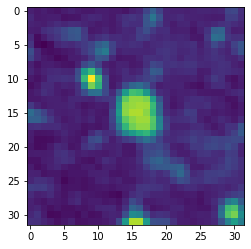

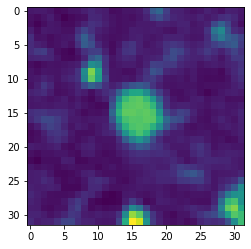

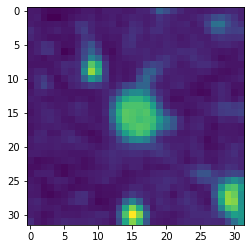

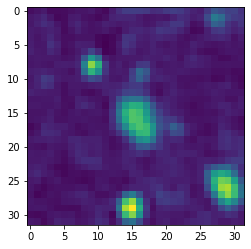

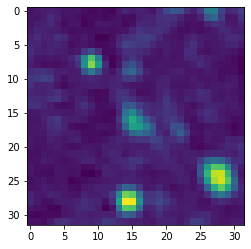

torch.Size([1, 5, 32, 32])


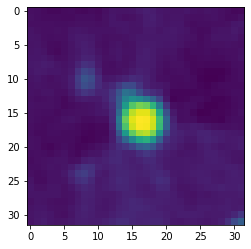

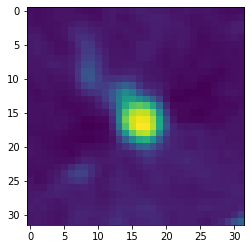

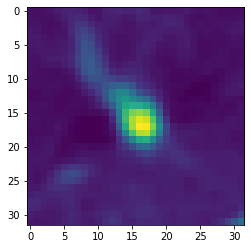

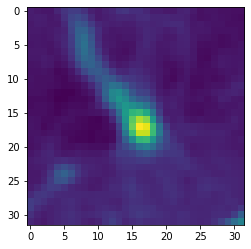

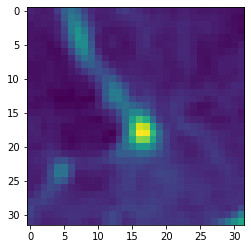

torch.Size([1, 5, 32, 32])


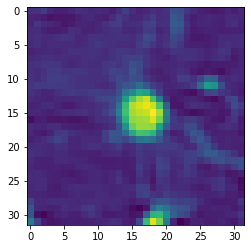

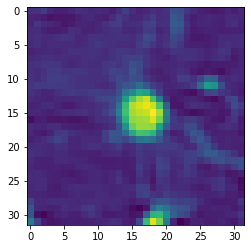

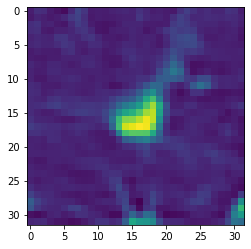

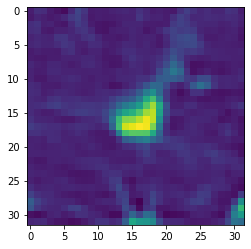

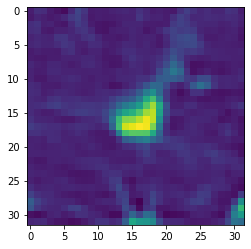

torch.Size([1, 5, 32, 32])


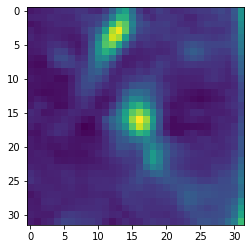

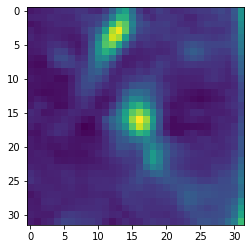

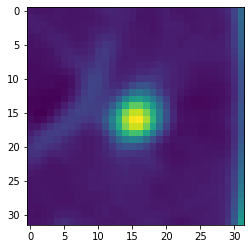

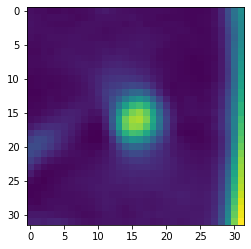

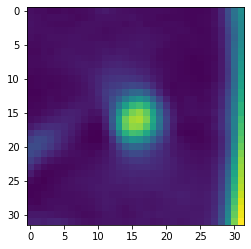

torch.Size([1, 5, 32, 32])


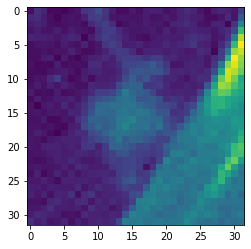

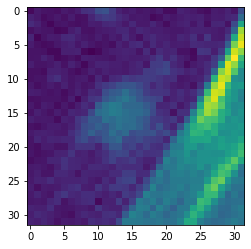

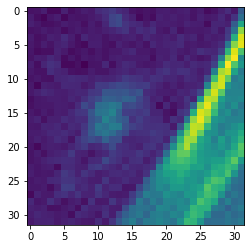

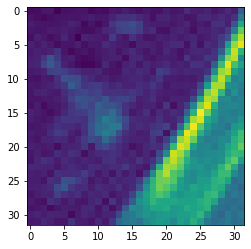

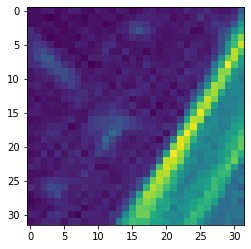

torch.Size([1, 5, 32, 32])


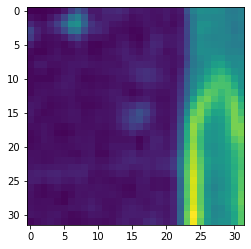

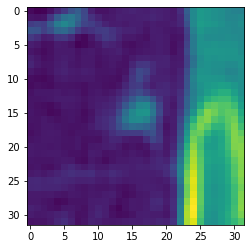

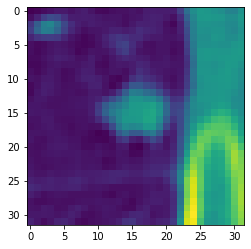

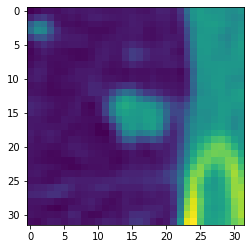

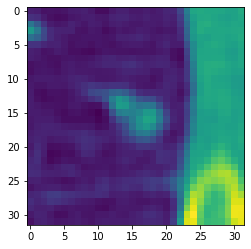

torch.Size([1, 5, 32, 32])


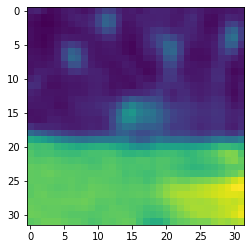

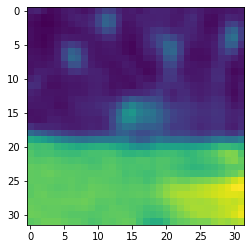

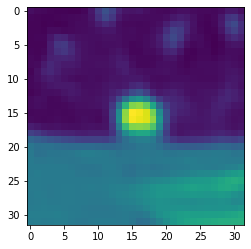

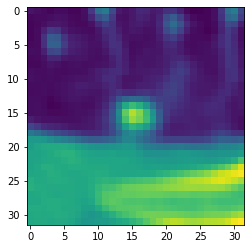

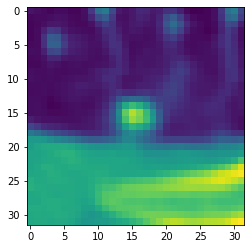

torch.Size([1, 5, 32, 32])


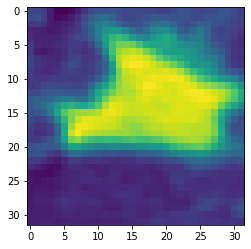

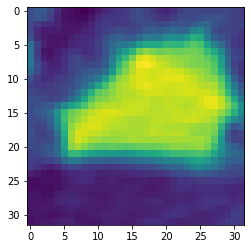

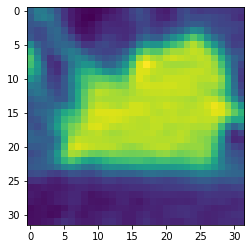

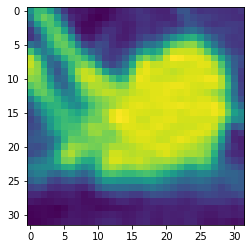

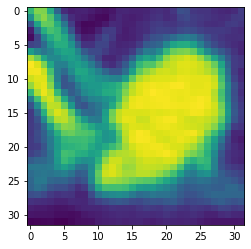

torch.Size([1, 5, 32, 32])


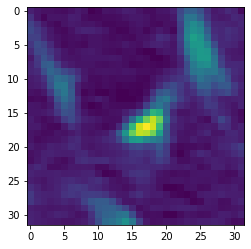

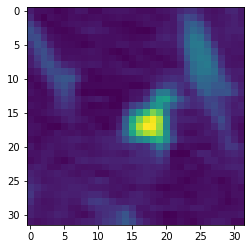

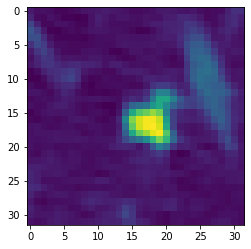

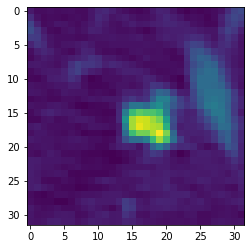

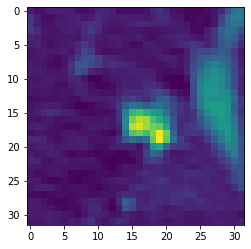

torch.Size([1, 5, 32, 32])


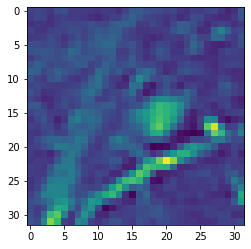

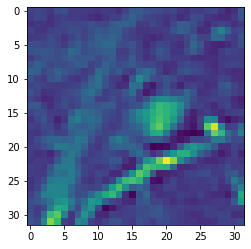

KeyboardInterrupt: 

In [20]:
for i, volumen in enumerate(x):
    print(volumen.shape, y[i])
    plt.imshow(volumen.permute(1,2,3,0)[0], cmap = "gray")
#     for j, value in enumerate(volumen.permute(1,2,3,0)):
#         plt.imshow(value)
#         plt.show()
#         plt.close()

In [18]:
print("          Train          ")
print("1", list(y_train).count(1))
print("2", list(y_train).count(2))
print("3", list(y_train).count(3))
print("4", list(y_train).count(4))
print("5", list(y_train).count(5))

print("          Test          ")
print("1", list(y_train).count(1))
print("2", list(y_train).count(2))
print("3", list(y_train).count(3))
print("4", list(y_train).count(4))
print("5", list(y_train).count(5))


          Train          
1 97
2 39
3 312
4 161
5 127
          Test          
1 97
2 39
3 312
4 161
5 127


In [19]:
img_size = 32; nodule_size = 16
def get_dataset_aug(directory_):
    T.manual_seed(0)
    
#     df_3R = pd.read_csv(os.path.join(LIDC_path, "meta_created_info_3d_3R.csv")) 
    df = pd.read_csv(os.path.join(LIDC_path, "meta_created_info_3d_4R.csv")) 
#     df = pd.concat([df_4R, df_3R])
    
    for c, row in enumerate(df["folder"]):
        patient_folder  = os.path.join(LIDC_path,row)
        length_folder   = len(os.listdir(patient_folder)) 
        if (length_folder == 2): df.drop(df[df['folder'] == row].index, inplace = True)
    
    X_train, X_test, y_train, y_test = train_test_split(df["folder"], df["malignancy"], test_size=0.20, random_state=100)
    num_data = len(X_train)
    print(len(X_train), len(X_test))
    
    aug_size = 6
    x = T.zeros((num_data * aug_size, 3, img_size, img_size))
    y = T.zeros((num_data * aug_size, len(T.Tensor([1., 0., 0., 0., 0.]))))
    augmenter = Augmenter(hflip=True, rotate=True, blurring=True)
    
    for c, row in enumerate(X_train):
        patient_folder  = os.path.join(LIDC_path,row)
        length_folder   = len(os.listdir(patient_folder)) 
        if (length_folder == 2): continue;
        image_folder    = sorted(os.listdir(patient_folder))
        middle_value    = len(image_folder)//2
        tensor_image_3d = [image_folder[middle_value-1], image_folder[middle_value], image_folder[middle_value+1]]

        patient = df[df['folder'] == row]
        for i, value in enumerate(tensor_image_3d):

            im = np.load(os.path.join(root, patient_folder, value))
            im = im - np.min(im)
            im = ((im/np.max(im))*255).astype(np.uint8)
            width, height = im.shape; width = width//2; height = height//2
            if((im.shape[0] < 32) or (im.shape[1] < 32)): im = cv.resize(im, (32, 32))
            elif((im.shape[0] < width+nodule_size) or (im.shape[1] < width+nodule_size)): im = cv.resize(im, (32, 32))
            else: im = im[width-nodule_size:width+nodule_size, width-nodule_size:width+nodule_size]

            for j, image in enumerate(augmenter.augment(im)):
                x[c * aug_size + j, i, :, :] = T.from_numpy(np.array(image).astype(np.float32))
                if(int(patient.malignancy) == 1): y[c * aug_size + j, 0:] = T.Tensor([1., 0., 0., 0., 0.])
                if(int(patient.malignancy) == 2): y[c * aug_size + j, 0:] = T.Tensor([0., 1., 0., 0., 0.])
                if(int(patient.malignancy) == 3): y[c * aug_size + j, 0:] = T.Tensor([0., 0., 1., 0., 0.])
                if(int(patient.malignancy) == 4): y[c * aug_size + j, 0:] = T.Tensor([0., 0., 0., 1., 0.])
                if(int(patient.malignancy) == 5): y[c * aug_size + j, 0:] = T.Tensor([0., 0., 0., 0., 1.])
        

    mu = x.mean()
    sd = x.std()
    x = (x - mu) / sd

    trainset = TensorDataset(x, y)
    num_data = len(X_test)
    x = T.zeros((num_data * aug_size, 3, img_size, img_size))
    y = T.zeros((num_data * aug_size, len(T.Tensor([1., 0., 0., 0., 0.]))))
    
    for c, row in enumerate(X_test):
        patient_folder  = os.path.join(LIDC_path,row)
        length_folder   = len(os.listdir(patient_folder)) 
        if (length_folder == 2): continue;
        image_folder    = sorted(os.listdir(patient_folder))
        middle_value    = len(image_folder)//2
        tensor_image_3d = [image_folder[middle_value-1], image_folder[middle_value], image_folder[middle_value+1]]

        patient = df[df['folder'] == row]
        for i, value in enumerate(tensor_image_3d):

            im = np.load(os.path.join(root, patient_folder, value))
            im = im - np.min(im)
            im = ((im/np.max(im))*255).astype(np.uint8)
            width, height = im.shape; width = width//2; height = height//2
            if((im.shape[0] < 32) or (im.shape[1] < 32)): im = cv.resize(im, (32, 32))
            elif((im.shape[0] < width+nodule_size) or (im.shape[1] < width+nodule_size)): im = cv.resize(im, (32, 32))
            else: im = im[width-nodule_size:width+nodule_size, width-nodule_size:width+nodule_size]

            for j, image in enumerate(augmenter.augment(im)):
                x[c * aug_size + j, i, :, :] = T.from_numpy(np.array(image).astype(np.float32))
                if(int(patient.malignancy) == 1): y[c * aug_size + j, 0:] = T.Tensor([1., 0., 0., 0., 0.])
                if(int(patient.malignancy) == 2): y[c * aug_size + j, 0:] = T.Tensor([0., 1., 0., 0., 0.])
                if(int(patient.malignancy) == 3): y[c * aug_size + j, 0:] = T.Tensor([0., 0., 1., 0., 0.])
                if(int(patient.malignancy) == 4): y[c * aug_size + j, 0:] = T.Tensor([0., 0., 0., 1., 0.])
                if(int(patient.malignancy) == 5): y[c * aug_size + j, 0:] = T.Tensor([0., 0., 0., 0., 1.])

    x = (x - mu) / sd
    testset = TensorDataset(x, y)

    return trainset, testset

In [25]:
img_size = 32; nodule_size = 16
def get_dataset(X_train, y_train, X_test, y_test, LIDC_path, df):
#     T.manual_seed(0)
    num_data = len(X_train)
    x = T.zeros((num_data, 1, 5, img_size, img_size))
    y = T.zeros((num_data, 1))
    
    for c, row in enumerate(X_train):
        patient_folder  = os.path.join(LIDC_path,row)
        length_folder   = len(os.listdir(patient_folder)) 
        image_folder    = sorted(os.listdir(patient_folder))
        middle_value    = len(image_folder)//2

        if (length_folder == 1): 
            tensor_image_3d = [image_folder, image_folder, image_folder, image_folder, image_folder]
        elif (length_folder == 2): 
            tensor_image_3d = [image_folder[0], image_folder[0], image_folder[1], image_folder[1], image_folder[1]]
        elif (length_folder == 3): 
            tensor_image_3d = [image_folder[0], image_folder[0], image_folder[1], image_folder[2], image_folder[2]]
        elif (length_folder == 4): 
            tensor_image_3d = [image_folder[0], image_folder[1], image_folder[2], image_folder[3], image_folder[3]]
        elif (length_folder >= 5): 
            tensor_image_3d = [image_folder[middle_value-2], image_folder[middle_value-1], image_folder[middle_value], 
                               image_folder[middle_value+1], image_folder[middle_value+2]]

        patient = df[df['folder'] == row]
        for i, value in enumerate(tensor_image_3d):

            im = np.load(os.path.join(root, patient_folder, value))
            im = im - np.min(im)
            im = ((im/np.max(im))*255).astype(np.uint8)
            width, height = im.shape; width = width//2; height = height//2
            if((im.shape[0] < 32) or (im.shape[1] < 32)): im = cv.resize(im, (32, 32))
            elif((im.shape[0] < width+nodule_size) or (im.shape[1] < width+nodule_size)): im = cv.resize(im, (32, 32))
            else: im = im[width-nodule_size:width+nodule_size, width-nodule_size:width+nodule_size]

            x[c, 0, i, :, :] = T.from_numpy(np.array(im).astype(np.float32))
            if(int(patient.malignancy) == 1): y[c, 0:] = int(1)
            if(int(patient.malignancy) == 2): y[c, 0:] = int(1)
            if(int(patient.malignancy) == 4): y[c, 0:] = int(1)
            if(int(patient.malignancy) == 5): y[c, 0:] = int(0)
                
    mu = x.mean()
    sd = x.std()
    x = (x - mu) / sd

    trainset = TensorDataset(x, y)
    num_data = len(X_test)
    x = T.zeros((num_data, 1, 5, img_size, img_size))
    y = T.zeros((num_data, 1))
    
    for c, row in enumerate(X_test):
        patient_folder  = os.path.join(LIDC_path,row)
        length_folder   = len(os.listdir(patient_folder)) 
        image_folder    = sorted(os.listdir(patient_folder))
        middle_value    = len(image_folder)//2

        if (length_folder == 1): 
            tensor_image_3d = [image_folder, image_folder, image_folder, image_folder, image_folder]
        elif (length_folder == 2): 
            tensor_image_3d = [image_folder[0], image_folder[0], image_folder[1], image_folder[1], image_folder[1]]
        elif (length_folder == 3): 
            tensor_image_3d = [image_folder[0], image_folder[0], image_folder[1], image_folder[2], image_folder[2]]
        elif (length_folder == 4): 
            tensor_image_3d = [image_folder[0], image_folder[1], image_folder[2], image_folder[3], image_folder[3]]
        elif (length_folder >= 5): 
            tensor_image_3d = [image_folder[middle_value-2], image_folder[middle_value-1], image_folder[middle_value], 
                               image_folder[middle_value+1], image_folder[middle_value+2]]
        patient = df[df['folder'] == row]
        for i, value in enumerate(tensor_image_3d):

            im = np.load(os.path.join(root, patient_folder, value))
            im = im - np.min(im)
            im = ((im/np.max(im))*255).astype(np.uint8)
            width, height = im.shape; width = width//2; height = height//2
            if((im.shape[0] < 32) or (im.shape[1] < 32)): im = cv.resize(im, (32, 32))
            elif((im.shape[0] < width+nodule_size) or (im.shape[1] < width+nodule_size)): im = cv.resize(im, (32, 32))
            else: im = im[width-nodule_size:width+nodule_size, width-nodule_size:width+nodule_size]

            x[c, 0, i, :, :] = T.from_numpy(np.array(im).astype(np.float32))
            if(int(patient.malignancy) == 1): y[c, 0:] = int(1)
            if(int(patient.malignancy) == 2): y[c, 0:] = int(1)
            if(int(patient.malignancy) == 4): y[c, 0:] = int(1)
            if(int(patient.malignancy) == 5): y[c, 0:] = int(0)
                
    x = (x - mu) / sd
    testset = TensorDataset(x, y)

    return trainset, testset

## Transfer learning
Create each validate and train function

In [26]:
from sklearn.preprocessing import OneHotEncoder
class Trainer:
    def __init__(self, training_set, validation_set,batch_size, n_epochs, model, optimizer, loss, name, device='cuda',
                 deterministic=False, parallel=False):

        T.backends.cudnn.deterministic = deterministic
        self.batch_size = batch_size
        self.dataset = training_set
        self.valid_dataset = validation_set

        self.model = model
        self.device = device
        self.parallel = parallel
        if parallel:
            self.model = nn.DataParallel(model)
        self.model.cuda(self.device)
        self.optimizer = optimizer
        self.loss = loss
        self.n_epochs = n_epochs
        self.name = name
        self.log = ''


    def train_epoch(self, epoch):
        s_time = time.time()
        self.model.train()
        all_losses = []
        all_acc = []
        for data, target in self.dataset:
            data, target = data.cuda(self.device), target.cuda(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            acc = self.calc_accuracy(output, target)
            #Si se usa la V2, se necesita realizar un .mean()
            loss = self.loss(output, target)
            loss.backward()
            self.optimizer.step()
            all_losses.append(loss.item())
            all_acc.append(acc.cpu())

        valid_acc = self.validate()
        self.report(all_losses, all_acc, valid_acc, epoch, time.time() - s_time)
        
    def report(self, all_losses, all_acc, valid_acc, epoch, duration):
        n_train = len(all_losses)
        loss = np.sum(all_losses) / n_train

        def summery(data):
            n = 0.0
            s_dist = 0
            for dist in data:
                s_dist += T.sum(dist)
                n += len(dist)

            return s_dist.float() / n

        tr_dist = summery(all_acc)
        va_dist = summery(valid_acc)
        
        
        dataset_valid, target, pred = self.predict()
        fpr, tpr, thresholds = metrics.roc_curve(target, pred)
        auc = metrics.auc(fpr, tpr)

        msg = f'epoch {epoch}: loss {loss:.3f} Tr Acc {tr_dist:.2f} Val Acc {va_dist:.2f} AUC {auc:.2f} duration {duration:.2f}'
        print(msg)
        self.log += msg + '\n'


    def predict(self):
        self.model.eval()
        all_pred = T.zeros(len(self.valid_dataset.dataset))
        all_targets = T.zeros(len(self.valid_dataset.dataset)); all_dataset = []; 
        for batch_idx, (data, target) in enumerate(self.valid_dataset):
            with T.no_grad():
                data, target = data.cuda(self.device), target.cuda(self.device)
                output = self.model(data)
                
            st = batch_idx * self.batch_size
            all_dataset.append(data)
            all_pred[st:st + output.shape[0]] = output.cpu().squeeze()
            all_targets[st:st + target.shape[0]] = target.cpu().squeeze()
        
        return all_dataset, all_targets, all_pred  


    def validate(self):
        dataset_valid, targets_append, pred_append = self.predict()
        matches = self.calc_accuracy(pred_append, targets_append)
        return [matches]

    def calc_accuracy(self, x, y):
        x_th = (x > 0.5).long()
        matches = x_th == y.long()
        return matches

    def run(self):
        start_t = time.time()
        for epoch in range(self.n_epochs):
            self.train_epoch(epoch)
        diff = time.time() - start_t
        print(f'took {diff} seconds')
        with open(os.path.join('results',f'{self.name}.txt'),'w') as f:
            f.write(self.log)
        print(f'took {diff} seconds')

In [27]:
def get_metrics(target, pred):
    prec, recall, _, _ = metrics.precision_recall_fscore_support(target, pred>0.5, average='binary')
    fpr, tpr, thresholds = metrics.roc_curve(target, pred)
    auc = metrics.auc(fpr, tpr)
    conf_mat = 0
    return prec, recall, auc

def calc_accuracy(x, y):
    x_th = (x > 0.5).long()
    matches = x_th == y.long()
    return matches

def reset_rand():
    seed = 1000
    T.manual_seed(seed)
    T.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

embedding_layer = {}
def get_activation(name):
    def hook(model, input, output):
        embedding_layer[name] = output.detach()
    return hook

def kfold(src_path, batch_size, n_epochs, loss, model_optimizer, name, device, deterministic=False, parallel=False,
          dataset_func=get_dataset):

    print(f'Experiment {name}')
    all_pred = T.zeros(921); all_dataset = []; targets_app = T.zeros(921)
    i = 0; fold = 0
    f = open(os.path.join('results', f'{name}.txt'), 'w')
    f.write(f'{batch_size} {n_epochs} {"Optimizer: Adam"}\n')
    
    df_3R = pd.read_csv(os.path.join(LIDC_path, "meta_created_info_3d_3R.csv")) 
    df_4R = pd.read_csv(os.path.join(LIDC_path, "meta_created_info_3d_4R.csv")) 
    df_all = pd.concat([df_4R, df_3R]).reset_index()
    df_benign = df_all[df_all['malignancy']<3]
    df_malign = df_all[df_all['malignancy']>3]
    df = pd.concat([df_benign, df_malign]).reset_index()
    
    skf = StratifiedKFold(n_splits=10, shuffle=False)
    skf.get_n_splits(df["folder"], df["malignancy"])
    
    for train_index, test_index in skf.split(df["folder"], df["malignancy"]):
        reset_rand()
        X_train, X_test = df["folder"][train_index], df["folder"][test_index]
        y_train, y_test = df["malignancy"][train_index], df["malignancy"][test_index]
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        trset, testset = dataset_func(X_train, y_train, X_test, y_test, src_path, df)
        
        print(f'------------ fold {fold+1} ------------')
        f.write(f'------------ fold {fold+1} ------------\n')
        print(f'Training Size: {len(trset)}, Validation Size: {len(testset)}')
        trset = DataLoader(trset, batch_size, shuffle=True)
        testset = DataLoader(testset, batch_size, shuffle=False)
        model,optimizer = model_optimizer()

        tr = Trainer(trset, testset, batch_size, n_epochs, model, optimizer, loss, f'{name}_{fold + 1}', device, 
                     deterministic, parallel)
        tr.run()

        dataset_valid, targets_, pred_ = tr.predict()
        T.save(model.state_dict(), f'results/{name}_fold_{fold}.pth')

        
        all_pred[i:i+pred_.shape[0]] = pred_
        all_dataset.append(dataset_valid)
        targets_app[i:i+targets_.shape[0]] = targets_
        i += targets_.shape[0]; fold += 1 

        prec, recall, auc = get_metrics(targets_, pred_)
        print(f'AUC: {auc}, Precision : {prec}, Recall: {recall}')
        f.write(f'AUC: {auc}, Precision : {prec}, Recall: {recall}\n')
                
        del tr

    T.save(all_dataset, f'results/completeDataset_{name}')
    T.save(all_pred, f'results/pedict_{name}')
    T.save(targets_app, f'results/target_{name}')
    
    matches = calc_accuracy(all_pred, targets_app)
    acc = matches.float().mean()
    all_pred = all_pred.numpy()
    targets_app = targets_app.numpy()
    #all_dataset = all_dataset.numpy()

    print("Finalizing")
    prec, recall, auc = get_metrics(targets_app, all_pred)
    print(f'all_pred: {all_pred}, all_targets {targets_app}')
    print(f'accuray: {acc}, AUC: {auc}, Precision : {prec}, Recall: {recall}')
    f.write(f'accuray: {acc}, AUC: {auc}, Precision : {prec}, Recall: {recall}')
    result = {'all_pred': all_pred, 'all_targets': targets_app}
    return all_pred, all_dataset, targets_app

In [28]:
def model_opt():
    model = RFBMultiHAttnNetwork_V3()
    optm = Adam(model.parameters())#, lr=0.00001)
    return model, optm

all_pred, all_dataset, all_targets =  kfold(LIDC_path,
                                            64,
                                            50,
                                            loss = nn.BCELoss(),
                                            model_optimizer = model_opt,
                                            name = 'Journal_3D_3VSALL_noind',
                                            device = 'cuda',
                                            deterministic = True,
                                            dataset_func = get_dataset)

Experiment Journal_3D_3VSALL_noind
(479,) (479,) (54,) (54,)
------------ fold 1 ------------
Training Size: 479, Validation Size: 54
epoch 0: loss 0.614 Tr Acc 0.70 Val Acc 0.74 AUC 0.81 duration 29.38
epoch 1: loss 0.587 Tr Acc 0.71 Val Acc 0.74 AUC 0.84 duration 29.63
epoch 2: loss 0.563 Tr Acc 0.73 Val Acc 0.76 AUC 0.86 duration 29.68
epoch 3: loss 0.539 Tr Acc 0.76 Val Acc 0.83 AUC 0.90 duration 29.71
epoch 4: loss 0.513 Tr Acc 0.78 Val Acc 0.80 AUC 0.89 duration 29.74
epoch 5: loss 0.494 Tr Acc 0.79 Val Acc 0.74 AUC 0.91 duration 29.75
epoch 6: loss 0.479 Tr Acc 0.80 Val Acc 0.67 AUC 0.90 duration 29.77
epoch 7: loss 0.450 Tr Acc 0.81 Val Acc 0.78 AUC 0.91 duration 29.79
epoch 8: loss 0.446 Tr Acc 0.80 Val Acc 0.85 AUC 0.91 duration 29.77
epoch 9: loss 0.421 Tr Acc 0.81 Val Acc 0.74 AUC 0.91 duration 29.82
epoch 10: loss 0.397 Tr Acc 0.81 Val Acc 0.78 AUC 0.89 duration 29.83
epoch 11: loss 0.380 Tr Acc 0.82 Val Acc 0.70 AUC 0.92 duration 29.83
epoch 12: loss 0.354 Tr Acc 0.84 Val